In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import torchvision
import torch.optim as optim

import numpy as np
from sklearn.manifold import TSNE

import argparse, sys, os

import torch
from torchtext import data, datasets
import random
torch.backends.cudnn.deterministic = True

import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.nn.init as init
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import time
from collections import Counter
import matplotlib.pyplot as plt 


In [2]:
from google.colab import files
uploaded = files.upload()

In [3]:
import pandas as pd

import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
nltk.download('stopwords')

wiki = pd.read_csv("Wiki.csv")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# remove puctunations, https
import re
def  clean_text(df, text_field):
    df[text_field] = df[text_field].str.lower()
    df[text_field] = df[text_field].apply(lambda elem: re.sub(r"(@[A-Za-z]+)|([^A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))
    return df

wiki = clean_text(wiki, 'text')

stopwords = nltk.corpus.stopwords.words('english')
wiki['text'] = wiki['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))

In [5]:
wiki = wiki[['text', 'label']]

In [6]:
wiki.to_csv('W.csv', index=False)

#tokenize

In [7]:
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [8]:
TEXT = data.Field(tokenize = 'spacy', batch_first=True)
LABEL = data.LabelField(dtype=torch.float)

In [9]:
#loading custom dataset
W =data.TabularDataset(path = 'W.csv',format = 'csv',fields = [('text', TEXT),('label',LABEL)],skip_header = True)

#print preprocessed text
print(vars(W.examples[0]))

{'text': ['right', 'fine', 'did', 'nt', 'even', 'start', 'discussion', 'joined', 'every', 'time', 'someone', 'tries', 'get', 'article', 'neutral', 'bullheaded', 'evolutionist', 'jumps', 'throat', 'stupid', 'evolution', 'proven', 'you', 're', 'idiot'], 'label': '1.0'}


#split train, test, val

In [10]:
def split(train_size, dataset):
  train, test = dataset.split([6000, 2000], random_state = random.seed(SEED))
  train, other = train.split([train_size, 6000-train_size], random_state = random.seed(SEED))
  # train, val = train.split(random_state = random.seed(SEED))
  return train, test

train_size = 1000
W_train_data, W_test_data = split(train_size, W)


#convert texts into integer sequences.

build vocabulary

In [11]:
#initialize glove embeddings
MAX_VOCAB_SIZE = 25_000

TEXT.build_vocab(W_train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_) 
LABEL.build_vocab(W_train_data,)

creat iterators

In [12]:
#set batch size
BATCH_SIZE = 64

#check whether cuda is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  

W_train_iterator, W_test_iterator = data.BucketIterator.splits(
    (W_train_data, W_test_data), 
    batch_size = BATCH_SIZE, 
    sort_key = lambda x: len(x.text),
    sort_within_batch=True,
    device = device)

In [13]:
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx, pretrained_embeddings):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        self.embedding.weight.data.copy_(pretrained_embeddings)
        self.conv_0 = nn.Conv2d(in_channels = 1, 
                                out_channels = n_filters, 
                                kernel_size = (filter_sizes, embedding_dim))
        
        
        
        self.fc = nn.Linear(n_filters, output_dim)     
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
                
        #text = [batch size, sent len]
        
        embedded = self.embedding(text)
                
        #embedded = [batch size, sent len, emb dim]
        
        embedded = embedded.unsqueeze(1)
        
        #embedded = [batch size, 1, sent len, emb dim]
        
        conved_0 = F.relu(self.conv_0(embedded).squeeze(3))
            
        #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]
        
        pooled_0 = F.max_pool1d(conved_0, conved_0.shape[2]).squeeze(2)
        
        #pooled_n = [batch size, n_filters]
        x = self.dropout(pooled_0)
        #x = [batch size, n_filters * len(filter_sizes)]
            
        return self.fc(x)

In [14]:
def optimizer_scheduler(optimizer, p):
    """
    Adjust the learning rate of optimizer
    :param optimizer: optimizer for updating parameters
    :param p: a variable for adjusting learning rate
    :return: optimizer
    """
    for param_group in optimizer.param_groups:
        param_group['lr'] = 0.01 / (1. + 10 * p) ** 0.75

    return optimizer

In [15]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
N_FILTERS = 100
FILTER_SIZES = 1
OUTPUT_DIM = 1
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
pretrained_embeddings = TEXT.vocab.vectors

model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX,pretrained_embeddings )

check the number of parameters

In [16]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 835,101 trainable parameters


zero the initial weights of the unknown and padding tokens







In [17]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

In [18]:
criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

define function to calculate the correct predictions

In [19]:
def train(training_mode, model, criterion,
          train_data, optimizer, epoch):
  
    epoch_loss = 0
    epoch_acc = 0

    # setup models
    model.train()


    # steps
    start_steps = epoch * len(train_data)
    total_steps = 10 * len(train_data)

    for batch_idx, data in enumerate (train_data):
        if training_mode == 'dann':
            # setup hyperparameters
            p = float(batch_idx + start_steps) / total_steps
            constant = 2. / (1. + np.exp(-gamma * p)) - 1

            # prepare the data
            input1, label1 = data.text, data.label
            # setup optimizer
            optimizer = optimizer_scheduler(optimizer, p)
            optimizer.zero_grad()

            output1 = model(input1).squeeze(1)
            loss1 = criterion(output1, label1)
            
            loss = loss1

            loss.backward()
            optimizer.step()

            # print loss

            if (batch_idx + 1) % 10 == 0:
                print('[{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    batch_idx * len(input1), len(W_train_data),
                    100. * batch_idx / len(train_data), loss.item()
                ))
                
            total_loss.append(loss.item())
   

In [20]:
def test(model, test_data):
 
    # setup the network
    model.eval()
    correct = 0.0
   
    for batch_idx, sdata in enumerate(test_data):
        # setup hyperparameters
        p = float(batch_idx) / len(test_data)
        constant = 2. / (1. + np.exp(-10 * p)) - 1.

        input1, label1= sdata.text, sdata.label
        
        output1 = model(input1).squeeze(1)
        output1 = torch.round(torch.sigmoid(output1))
        correct += (output1 == label1).cpu().sum()

    print('\n Accuracy: {}/{} ({:.4f}%)\n'.
        format(
        correct, len(W_test_data), 100. * float(correct) / len(W_test_data),
        
    ))
    acc_list1.append(100. * float(correct) / len(W_test_data))
    

In [21]:
def main():

    # prepare the source data and target data
    src1_train_data = W_train_iterator
    src1_test_data = W_test_iterator

    # src2_train_data = F_train_iterator
    # src2_test_data = F_test_iterator
    
    # tgt_train_data = W_train_iterator
    # tgt_test_data = W_test_iterator

    optimizer = optim.SGD([
            {'params': model.parameters()}
                           
    ], lr= 0.01, momentum= 0.9)


    for epoch in range(100):
    
        print('Epoch: {}'.format(epoch))
        train('dann', model, criterion,
                    src1_train_data, optimizer, epoch)
        test(model, src1_test_data)
        
total_loss = []
acc_list1 = []
if __name__ == '__main__':
    gamma = 10
    theta = 1
    time_start=time.time()
    main()
    time_end=time.time()
    print('total run time: (min)',(time_end-time_start)/60.)

Epoch: 0
[576/1000 (56%)]	Loss: 0.779910

 Accuracy: 1217.0/2000 (60.8500%)

Epoch: 1
[576/1000 (56%)]	Loss: 0.660349

 Accuracy: 1443.0/2000 (72.1500%)

Epoch: 2
[576/1000 (56%)]	Loss: 0.709458

 Accuracy: 1540.0/2000 (77.0000%)

Epoch: 3
[576/1000 (56%)]	Loss: 0.720658

 Accuracy: 1544.0/2000 (77.2000%)

Epoch: 4
[360/1000 (56%)]	Loss: 0.711241

 Accuracy: 1619.0/2000 (80.9500%)

Epoch: 5
[576/1000 (56%)]	Loss: 0.594156

 Accuracy: 1623.0/2000 (81.1500%)

Epoch: 6
[576/1000 (56%)]	Loss: 0.588918

 Accuracy: 1605.0/2000 (80.2500%)

Epoch: 7
[576/1000 (56%)]	Loss: 0.573255

 Accuracy: 1646.0/2000 (82.3000%)

Epoch: 8
[576/1000 (56%)]	Loss: 0.628642

 Accuracy: 1635.0/2000 (81.7500%)

Epoch: 9
[576/1000 (56%)]	Loss: 0.597133

 Accuracy: 1642.0/2000 (82.1000%)

Epoch: 10
[576/1000 (56%)]	Loss: 0.524515

 Accuracy: 1660.0/2000 (83.0000%)

Epoch: 11
[576/1000 (56%)]	Loss: 0.587741

 Accuracy: 1659.0/2000 (82.9500%)

Epoch: 12
[576/1000 (56%)]	Loss: 0.640167

 Accuracy: 1661.0/2000 (83.0500

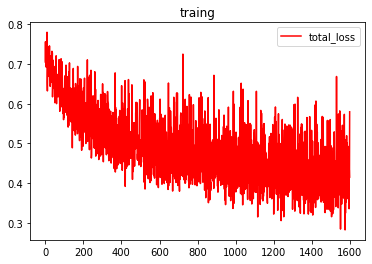

In [22]:
plt.plot(range(len(total_loss)),total_loss,c='r',label='total_loss')
plt.title('traing')
plt.legend(loc='best')
plt.show()

max target accuracy:  84.55


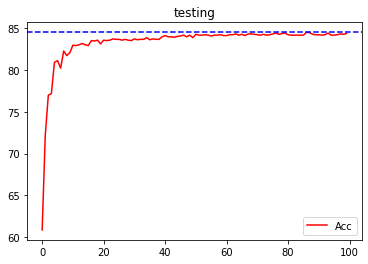

In [23]:
print('max target accuracy: ',max(acc_list1))
plt.plot(range(len(acc_list1)),acc_list1,c='r',label='Acc')
plt.axhline(max(acc_list1),c='b',linestyle='--')
plt.title('testing')
plt.legend(loc='best')
plt.show()

[68.1, 80.0, 82.4, 83.8, 84.55]